# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

## Sources

In [2]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [3]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.4, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(1E47 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(1E5 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.42344, Emin, Emax)
my_sources = Sources()
my_sources.add(point_source)
my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 
my_sources.add_atmospheric_component() # auto atmo component

In [4]:
my_sources.associated_fraction()

<Quantity 0.13348575>

## Simulation

In [5]:
from python.simulation import Simulation
from python.detector_model import NorthernTracksDetectorModel

In [9]:
obs_time = 10 * u.year
sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim.setup_and_run()
sim.save("output/test_sim_file.h5")

Using cached StanModel
Using cached StanModel


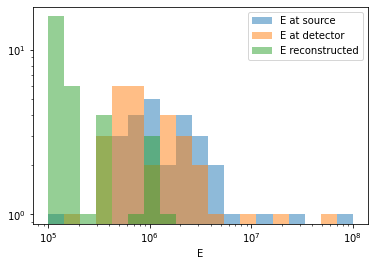

In [10]:
fig, ax = sim.show_spectrum()

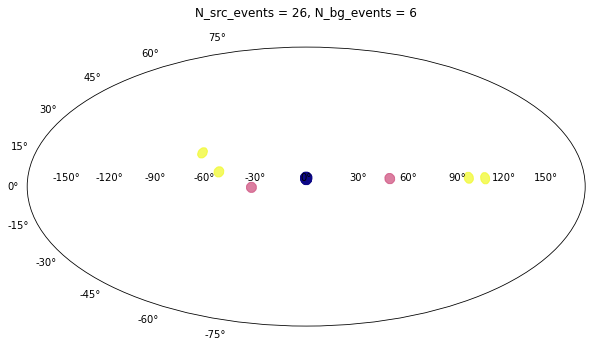

In [11]:
fig, ax = sim.show_skymap()

## Fit 

In [8]:
from python.events import Events
from python.fit import StanFit
from python.detector_model import NorthernTracksDetectorModel

In [10]:
events = Events.from_file("output/test_sim_file.h5")
obs_time = 10 * u.year

In [11]:
fit = StanFit(my_sources, NorthernTracksDetectorModel, events, obs_time)
#fit.setup_and_run()

In [21]:
fit.run()

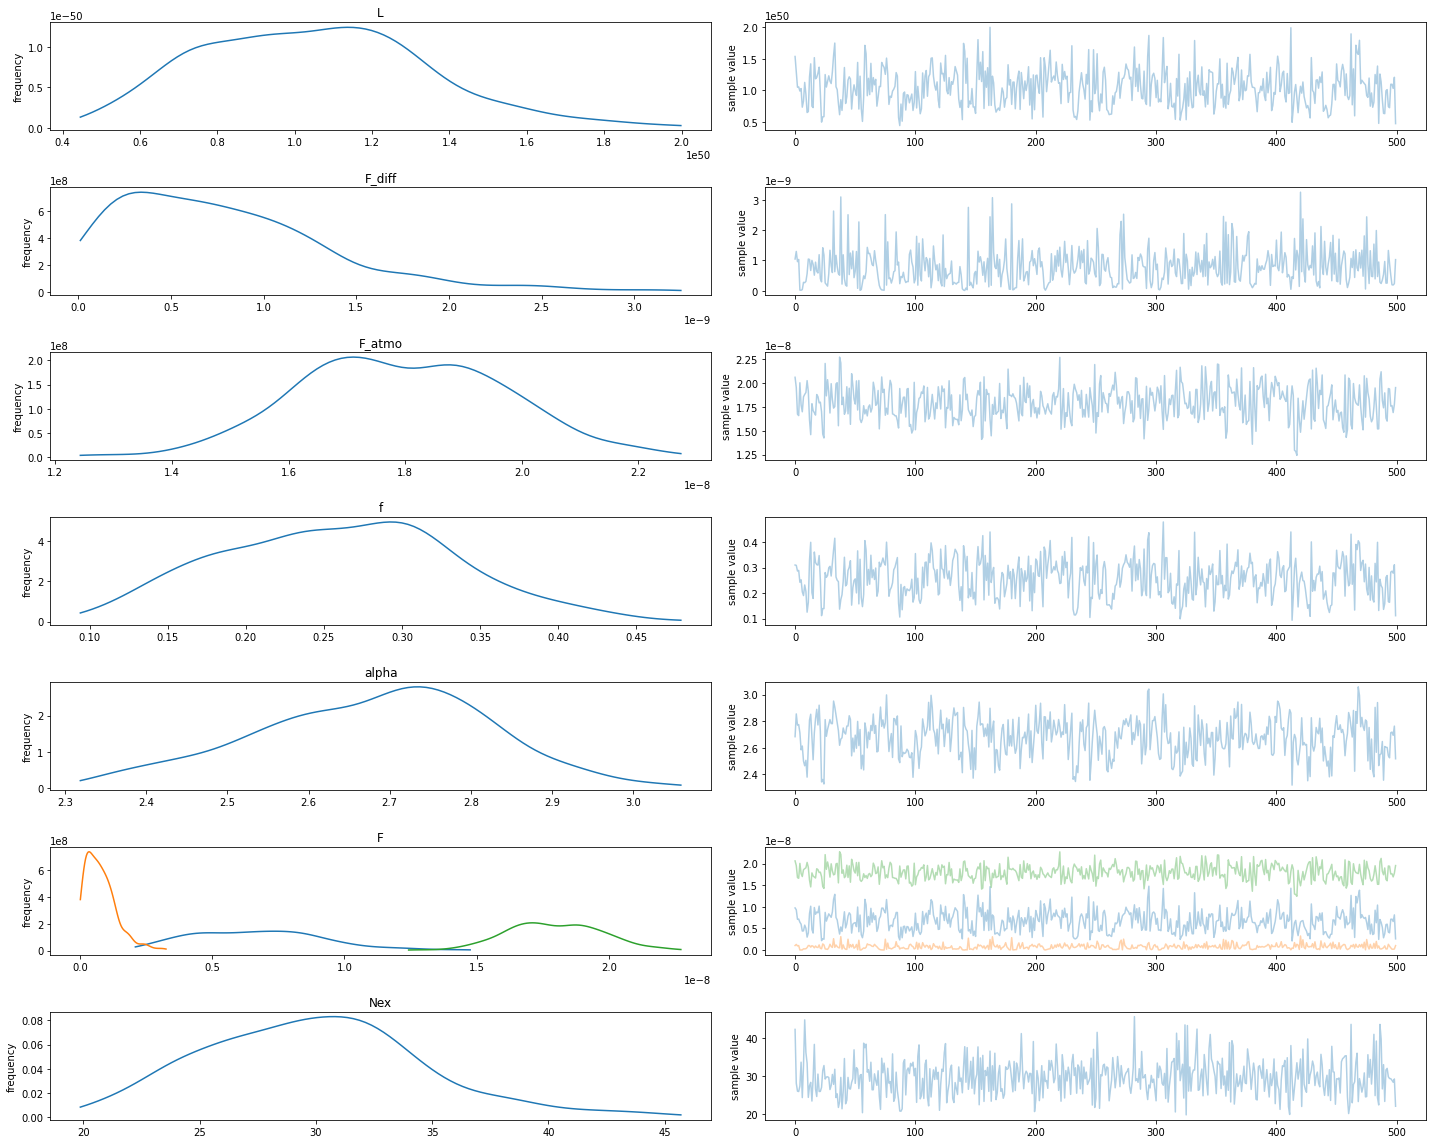

In [22]:
# View chains
fig = fit._fit_output.plot([r'L', r'F_diff', r'F_atmo', r'f', r'alpha', r'F', r"Nex"]);
fig.set_size_inches(20, 16)
fig.tight_layout()

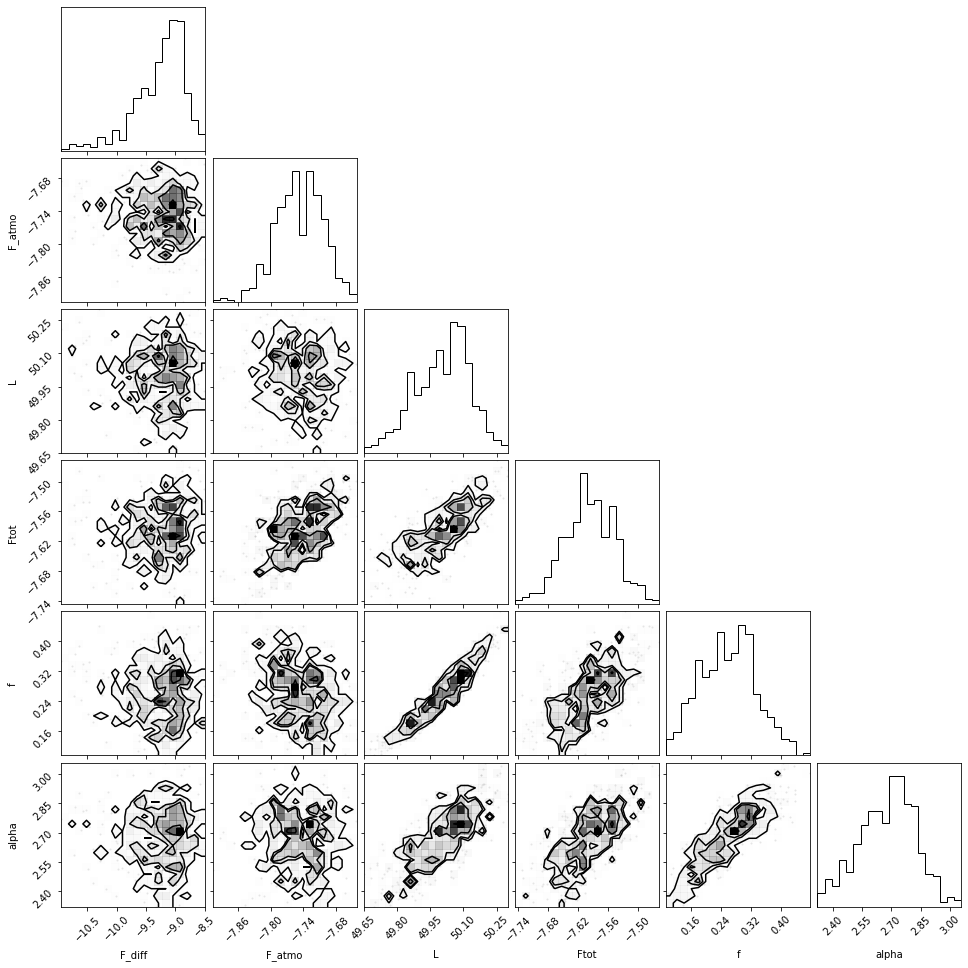

In [25]:
# View corner plot
chain = fit._fit_output.extract(permuted = True)
key_list = ['F_diff', 'F_atmo', 'L', 'Ftot', 'f', 'alpha']
labels = [r'F_diff', 'F_atmo', r'L', r'Ftot', r'f', 'alpha']
#truths = [np.log10(sim_inputs['F_diff']), np.log10(sim_inputs['F_atmo']), 
#          np.log10(sim_inputs['L']), np.log10((sum(source_ints)).value), 
#          (sum(source_ints[:-2]) / sum(source_ints)).value, 
#          sim_inputs['alpha']]

corner.corner(np.column_stack([np.log10(chain['F_diff']), np.log10(chain['F_atmo']), 
                               np.log10(chain['L']), np.log10(chain['Ftot']), 
                               chain['f'], chain['alpha']]),
              labels = labels);#, truths = truths);

In [26]:
#chain = fit.extract(permuted = True)
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background components
Ns = np.shape(logprob)[1] - 2
labels = ["src", "diff", "atmo"]

In [27]:
# Calculate association probabilities for each source-neutrino combo
nu_p = []
for lp in logprob:
    lps = []
    for src in range(Ns+2):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+2):
        ps.append(lps[src] / norm)
    nu_p.append(ps)

# Normalise line weights
pmax = max(max(nu_p))

In [28]:
# Check individual event classifications
counter = 0
wrong = []
for i in range(len(nu_p)):
    classified = np.where(nu_p[i] == np.max(nu_p[i]))[0][0] == int(lam[i])
    if not classified:
        counter += 1
        wrong.append(i)
        print("P(src) =", nu_p[i][0])
        print("P(diff) =", nu_p[i][1])
        print("P(atmo) =", nu_p[i][2])
        print("Actual component is", labels[int(lam[i])])
print("")
print(counter, "events out of", len(nu_p), "misclassified")

NameError: name 'lam' is not defined